In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

## Load Data

In [2]:
import cifar10

The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class-names.

In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Load the test-set.

In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


The data dimensions are used in several places in the source-code below. They have already been defined in the cifar10 module, so we just need to import them.

In [8]:
from cifar10 import img_size, num_channels, num_classes

The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels.

In [9]:
img_size_cropped = 24

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Plot a few images to see if data is correct

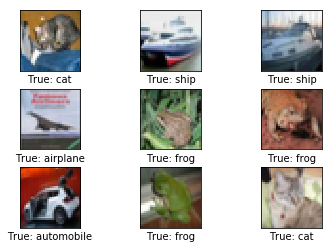

In [11]:
images = images_test[0:9]
cls_true = cls_test[0:9]
plot_images(images=images, cls_true=cls_true, smooth=False)

The pixelated images above are what the neural network will get as input. The images might be a bit easier for the human eye to recognize if we smoothen the pixels.

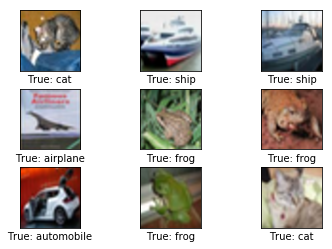

In [12]:
plot_images(images=images, cls_true=cls_true, smooth=True)

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

In [14]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [15]:
y_true_cls = tf.argmax(y_true, axis=1)

### Data augmentation for images

In [16]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. A simple solution is to limit the range.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

The function above is called for each image in the input batch using the following function.

In [17]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In order to plot the distorted images, we create the pre-processing graph for TensorFlow, so we may execute it later.

In [18]:
distorted_images = pre_process(images=x, training=True)

### Creating Main Processing

https://github.com/google/prettytensor/blob/master/prettytensor/pretty_tensor_image_methods.py

In [19]:
def main_network(images, training):
    
    images = tf.cast(images, tf.float32)
    x_pretty = pt.wrap(images)

    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer
        
    # Can't wrap it to pretty tensor because 
    # 'Layer' object has no attribute 'local_response_normalization'
    normalize = lambda x: pt.wrap(
        tf.nn.local_response_normalization(x, depth_radius=5.0, bias=2.0, alpha=1e-4, beta=0.75))

    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        
        layers = []
        
        for i in ["left", "right"]:
            first_conv = x_pretty.\
                conv2d(kernel=5, depth=48, name='conv_1_' + i)
    
            first_conv_norm = normalize(first_conv)
            
            first_conv_norm_pool = first_conv_norm.\
                max_pool(kernel=3, stride=2, edges='VALID', name='pool_1_' + i)

            second_conv = first_conv_norm_pool.\
                conv2d(kernel=3, depth=128, bias=tf.ones_initializer(), name='conv_2_' + i)

            second_conv_norm = normalize(second_conv)
            
            second_conv_norm_pooled = pt.wrap(second_conv_norm).\
                max_pool(kernel=2, stride=2, edges='VALID', name='pool_2_' + i)
                
            layers.append(second_conv_norm_pooled)
            
            
        first_interlayer = pt.wrap(tf.concat([layers[-2], layers[-1]], axis=3))
        
        for i in ["left", "right"]:
            cur_layer = first_interlayer.\
                conv2d(kernel=3, depth=192, name='conv_3_' + i).\
                conv2d(kernel=3, depth=192, name='conv_4_' + i).\
                conv2d(kernel=3, depth=128, name='conv_5_' + i).\
                max_pool(kernel=3, stride=2, edges='VALID', name='pool_3_' + i)
            layers.append(cur_layer)
            
        second_interlayer = pt.wrap(tf.concat([layers[-2], layers[-1]], axis=3))
        print(second_interlayer.shape)
        
        y_pred, loss = second_interlayer.\
            flatten().\
            fully_connected(1024, name='fully_conn_1').\
            dropout(0.2, name='dropout_1').\
            fully_connected(512, name='fully_conn_2').\
            dropout(0.2, name='dropout_2').\
            fully_connected(10, name='fully_conn_3').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

### Creating Neural Network

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [20]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        images = x
        images = pre_process(images=images, training=training)
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Create Neural Network for Training Phase

Note that `trainable=False` which means that TensorFlow will not try to optimize this variable.

In [21]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Create the neural network to be used for training. The `create_network()` function returns both `y_pred` and `loss`, but we only need the `loss`-function during training.

In [22]:
_, loss = create_network(training=True)

[None, 2, 2, 256]


Create an optimizer which will minimize the `loss`-function. Also pass the `global_step` variable to the optimizer so it will be increased by one after each iteration.

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Create Neural Network for Test Phase / Inference

Now create the neural network for the test-phase. Once again the `create_network()` function returns the predicted class-labels `y_pred` for the input images, as well as the `loss`-function to be used during optimization. During testing we only need `y_pred`.

In [24]:
y_pred, _ = create_network(training=False)

[None, 2, 2, 256]


We then calculate the predicted class number as an integer. The output of the network `y_pred` is an array with 10 elements. The class number is the index of the largest element in the array.

In [25]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [26]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [27]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In order to save the variables of the neural network, so they can be reloaded quickly without having to train the network again, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point, which will be done further below.

In [28]:
saver = tf.train.Saver()

### Getting the Weights

Further below, we want to plot the weights of the neural network. When the network is constructed using Pretty Tensor, all the variables of the layers are created indirectly by Pretty Tensor. We therefore have to retrieve the variables from TensorFlow.

We used the names `layer_conv1` and `layer_conv2` for the two convolutional layers. These are also called variable scopes. Pretty Tensor automatically gives names to the variables it creates for each layer, so we can retrieve the weights for a layer using the layer's scope-name and the variable-name.

The implementation is somewhat awkward because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [29]:
def get_weights_variable(layer_name):
    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [30]:
weights_conv1 = get_weights_variable(layer_name='conv_1_left')
weights_conv2 = get_weights_variable(layer_name='conv_1_right')

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(weights_conv1).shape)

(5, 5, 3, 48)


In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(weights_conv2).shape)

(5, 5, 3, 48)


### Getting the Layer Outputs

Similarly we also need to retrieve the outputs of the convolutional layers. The function for doing this is slightly different than the function above for getting the weights. Here we instead retrieve the last tensor that is output by the convolutional layer.

In [33]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

Get the output of the convoluational layers so we can plot them later.

In [34]:
output_conv1 = get_layer_output(layer_name='conv_1_left')
output_conv2 = get_layer_output(layer_name='conv_1_right')

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [35]:
# to prevent tensorflow from allocating the totality of a GPU memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

### Restore or initialize variables

In [36]:
save_dir = 'checkpoints_alex_net/'

Create the directory if it does not exist.

In [37]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the base-filename for the checkpoints, TensorFlow will append the iteration number, etc.

In [38]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

First try to restore the latest checkpoint. This may fail and raise an exception e.g. if such a checkpoint does not exist, or if you have changed the TensorFlow graph.

In [39]:
try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from None
Failed to restore checkpoint. Initializing variables instead.


### Helper-function to get a random training-batch

There are 50,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [40]:
train_batch_size = 64

Function for selecting a random batch of images from the training-set.

In [41]:
def random_batch():
    num_images = len(images_train)

    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### Optimization

The progress is printed every 100 iterations. A checkpoint is saved every 1000 iterations and also after the last iteration.

In [42]:
def optimize(num_iterations):
    start_time = time.time()

    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        if (i_global % 200 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [43]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    incorrect = (correct == False)
    
    images = images_test[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Plot confusion matrix

In [44]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Calculating classifications

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [45]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    num_images = len(images)

    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [46]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for the classification accuracy

In [47]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [48]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Helper-function for plotting convolutional weights

In [49]:
def plot_conv_weights(weights, input_channel=0):

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Helper-function for plotting the output of convolutional layers

In [50]:
def plot_layer_output(layer_output, image):
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

## Examples of distorted input images

In order to artificially inflate the number of images available for training, the neural network uses pre-processing with random distortions of the input images. This should hopefully make the neural network more flexible at recognizing and classifying images.

This is a helper-function for plotting distorted input images.

In [51]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)
    
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

Helper-function for getting an image and its class-number from the test-set.

In [52]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

Get an image and its true class from the test-set.

In [53]:
img, cls = get_test_image(16)

Plot 9 random distortions of the image. If you re-run this code you will get slightly different results.

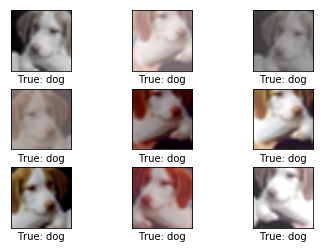

In [54]:
plot_distorted_image(img, cls)

## Perform optimization

In [55]:
tf.summary.FileWriter('graphs', sess.graph)

In [56]:
# if False:
optimize(num_iterations=100000)

Global Step:    200, Training Batch Accuracy:  14.1%
Global Step:    400, Training Batch Accuracy:   9.4%
Global Step:    600, Training Batch Accuracy:   4.7%
Global Step:    800, Training Batch Accuracy:  12.5%
Global Step:   1000, Training Batch Accuracy:   7.8%
Saved checkpoint.
Global Step:   1200, Training Batch Accuracy:   9.4%
Global Step:   1400, Training Batch Accuracy:  10.9%
Global Step:   1600, Training Batch Accuracy:  21.9%
Global Step:   1800, Training Batch Accuracy:  15.6%
Global Step:   2000, Training Batch Accuracy:  14.1%
Saved checkpoint.
Global Step:   2200, Training Batch Accuracy:  10.9%
Global Step:   2400, Training Batch Accuracy:  20.3%
Global Step:   2600, Training Batch Accuracy:  15.6%
Global Step:   2800, Training Batch Accuracy:  14.1%
Global Step:   3000, Training Batch Accuracy:  21.9%
Saved checkpoint.
Global Step:   3200, Training Batch Accuracy:  15.6%
Global Step:   3400, Training Batch Accuracy:  21.9%
Global Step:   3600, Training Batch Accuracy:

Global Step:  29200, Training Batch Accuracy:  57.8%
Global Step:  29400, Training Batch Accuracy:  75.0%
Global Step:  29600, Training Batch Accuracy:  73.4%
Global Step:  29800, Training Batch Accuracy:  67.2%
Global Step:  30000, Training Batch Accuracy:  59.4%
Saved checkpoint.
Global Step:  30200, Training Batch Accuracy:  48.4%
Global Step:  30400, Training Batch Accuracy:  53.1%
Global Step:  30600, Training Batch Accuracy:  65.6%
Global Step:  30800, Training Batch Accuracy:  57.8%
Global Step:  31000, Training Batch Accuracy:  60.9%
Saved checkpoint.
Global Step:  31200, Training Batch Accuracy:  60.9%
Global Step:  31400, Training Batch Accuracy:  57.8%
Global Step:  31600, Training Batch Accuracy:  62.5%
Global Step:  31800, Training Batch Accuracy:  70.3%
Global Step:  32000, Training Batch Accuracy:  59.4%
Saved checkpoint.
Global Step:  32200, Training Batch Accuracy:  71.9%
Global Step:  32400, Training Batch Accuracy:  68.8%
Global Step:  32600, Training Batch Accuracy:

Global Step:  58200, Training Batch Accuracy:  79.7%
Global Step:  58400, Training Batch Accuracy:  60.9%
Global Step:  58600, Training Batch Accuracy:  70.3%
Global Step:  58800, Training Batch Accuracy:  62.5%
Global Step:  59000, Training Batch Accuracy:  79.7%
Saved checkpoint.
Global Step:  59200, Training Batch Accuracy:  79.7%
Global Step:  59400, Training Batch Accuracy:  76.6%
Global Step:  59600, Training Batch Accuracy:  79.7%
Global Step:  59800, Training Batch Accuracy:  73.4%
Global Step:  60000, Training Batch Accuracy:  76.6%
Saved checkpoint.
Global Step:  60200, Training Batch Accuracy:  78.1%
Global Step:  60400, Training Batch Accuracy:  78.1%
Global Step:  60600, Training Batch Accuracy:  76.6%
Global Step:  60800, Training Batch Accuracy:  73.4%
Global Step:  61000, Training Batch Accuracy:  71.9%
Saved checkpoint.
Global Step:  61200, Training Batch Accuracy:  68.8%
Global Step:  61400, Training Batch Accuracy:  75.0%
Global Step:  61600, Training Batch Accuracy:

Global Step:  87200, Training Batch Accuracy:  79.7%
Global Step:  87400, Training Batch Accuracy:  82.8%
Global Step:  87600, Training Batch Accuracy:  73.4%
Global Step:  87800, Training Batch Accuracy:  76.6%
Global Step:  88000, Training Batch Accuracy:  82.8%
Saved checkpoint.
Global Step:  88200, Training Batch Accuracy:  87.5%
Global Step:  88400, Training Batch Accuracy:  82.8%
Global Step:  88600, Training Batch Accuracy:  76.6%
Global Step:  88800, Training Batch Accuracy:  82.8%
Global Step:  89000, Training Batch Accuracy:  75.0%
Saved checkpoint.
Global Step:  89200, Training Batch Accuracy:  76.6%
Global Step:  89400, Training Batch Accuracy:  70.3%
Global Step:  89600, Training Batch Accuracy:  81.2%
Global Step:  89800, Training Batch Accuracy:  79.7%
Global Step:  90000, Training Batch Accuracy:  79.7%
Saved checkpoint.
Global Step:  90200, Training Batch Accuracy:  71.9%
Global Step:  90400, Training Batch Accuracy:  85.9%
Global Step:  90600, Training Batch Accuracy:

## Results

Examples of mis-classifications are plotted below. 

Accuracy on Test-Set: 77.2% (7724 / 10000)
Example errors:


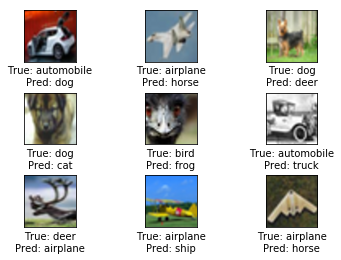

Confusion Matrix:
[807  12  43  18  13   1   6   8  59  33] (0) airplane
[ 16 856   4   5   4   4   6   3  31  71] (1) automobile
[ 53   5 701  57  46  52  36  29  11  10] (2) bird
[ 13   8  51 580  41 176  34  46  25  26] (3) cat
[ 14   5  52  62 686  53  30  82   7   9] (4) deer
[  6   2  45 145  29 687  14  54   2  16] (5) dog
[  3   4  44  52  22  35 802   8  14  16] (6) frog
[ 15   2  17  32  40  40   2 832   4  16] (7) horse
[ 38  21   7   6   3   2   2   1 889  31] (8) ship
[ 20  36   8   8   2   2   3   7  30 884] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [57]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Convolutional Weights

The following shows some of the weights (or filters) for the first convolutional layer. There are 3 input channels so there are 3 of these sets, which you may plot by changing the `input_channel`.

Note that positive weights are red and negative weights are blue.

Min:  -0.63871, Max:   0.52418
Mean: 0.00032, Stdev: 0.17259


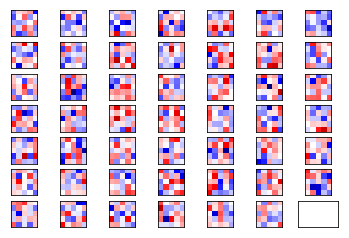

In [58]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

### Output of convolutional layers

Helper-function for plotting an image.

In [59]:
def plot_image(image):
    fig, axes = plt.subplots(1, 2)

    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    plt.show()

Plot an image from the test-set. The raw pixelated image is used as input to the neural network.

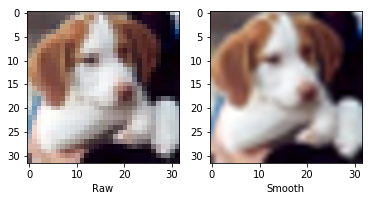

In [60]:
img, cls = get_test_image(16)
plot_image(img)

Use the raw image as input to the neural network and plot the output of the first convolutional layer.

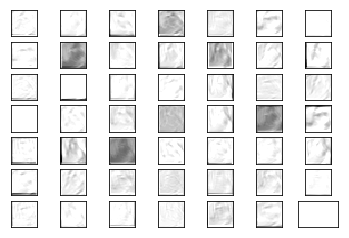

In [61]:
plot_layer_output(output_conv1, image=img)

Using the same image as input to the neural network, now plot the output of the second convolutional layer.

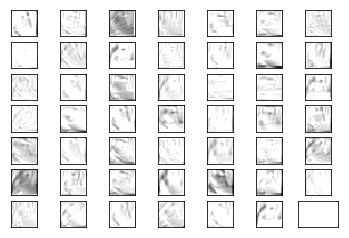

In [62]:
plot_layer_output(output_conv2, image=img)

### Predicted class-labels

Get the predicted class-label and class-number for this image.

In [63]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img]})

Print the predicted class-label.

In [64]:
# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])

[ 0.     0.     0.002  0.025  0.     0.973  0.     0.001  0.     0.   ]


In [65]:
class_names[3]

'cat'

In [66]:
class_names[5]

'dog'

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [67]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()